
<font size = "5"> **Chapter 2: [Diffraction](../Diffraction/CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# HW6:  Analyzing CBED Pattern

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Homework/Homework06.ipynb)


[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Homework/Homework06.ipynb)


 
part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes


## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2025.1.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

C:\Users\gduscher\AppData\Local\Temp\ipykernel_12584\2305901029.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import get_distribution, DistributionNotFound


installing pyTEMlib
done


### Import numerical and plotting python packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,

and some libraries from the book
* kinematic scattering library.
* file_tools library

In [1]:
%matplotlib  widget
import matplotlib.pyplot as plt
import numpy as np
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

# additional package 
import os
import  itertools 
import scipy.constants as const

import ipywidgets as ipyw

import sidpy
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # kinematic scattering Library
                             # atomic form factors from Kirkland's book
import pyTEMlib.file_tools 

__notebook_version__ = '2025.02.10'

print('pyTEM version: ', pyTEMlib.__version__)
print('notebook version: ', __notebook_version__)

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2025.04.2
notebook version:  2025.02.10


## Load CBED Pattern from Lab 4
>
>Please note, that this notebook will not work in Google colab becaus of the ``open file dialog``
>
First we select the diffraction pattern

In [4]:
# ------Input -------------
load_your_own_data = True
# -------------------------
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    load_your_own_data = True
if load_your_own_data:
   fileWidget = pyTEMlib.file_tools.FileWidget(sum_frames=True)
    

### Plotting on a logarithmic scale

The dynamic range in diffraction data is even larger than in images and so for a good presentation of the data it is advantagous to go to plot the intensities in a logarythmic scale.

To present data in logarythmic scale no nexgative values (noise) can be in these data and so all negative values in the dataset will be set to zero.

The factor 1 in front of the diffraction pattern in the log numpy function in the ``imshow`` is the gamma value.
Changing that value will change the contrast.

[-0.2016160637140274, 825.6177809089422, 825.6177809089422, -0.2016160637140274]


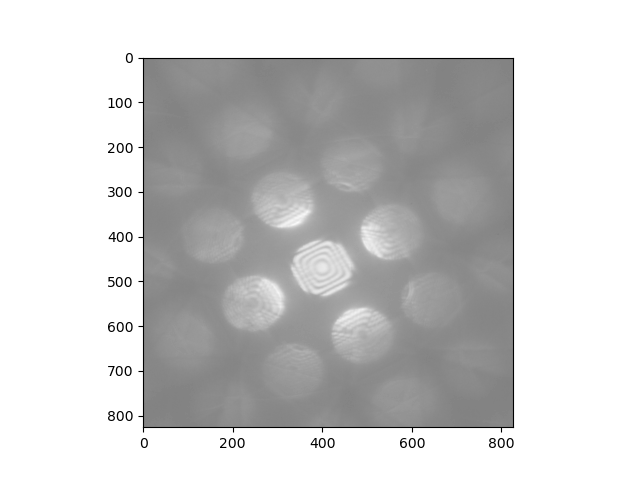

In [5]:
diff_pattern = fileWidget.selected_dataset
diff_pattern -= diff_pattern.min()

diff_pattern[diff_pattern<0] = 0.
extent = diff_pattern.get_extent([0,1])
print(extent)
fig = plt.figure() 
plt.imshow(np.log(1+diff_pattern),cmap="gray", vmin=np.max(np.log(1+diff_pattern))*0.5, extent=extent);



## Finding the center

### Selection of  center disk

Select the center disk with the ring selector


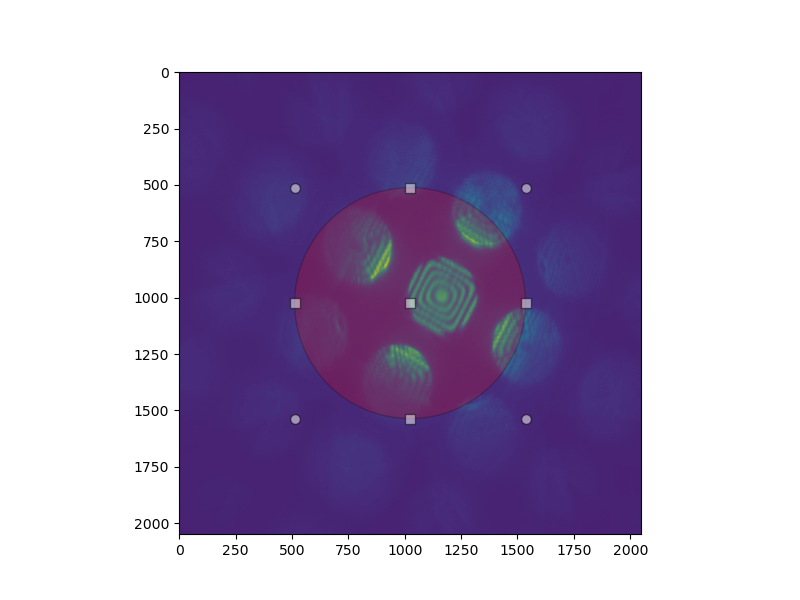

In [6]:
from matplotlib.widgets import  EllipseSelector

center = np.array([diff_pattern.shape[0]/2, diff_pattern.shape[1]/2])

plt.figure(figsize=(8, 6))
plt.imshow(diff_pattern.T, origin = 'upper')
selector = EllipseSelector(plt.gca(), None,interactive=True)  # gca get current axis (plot)
radius = diff_pattern.shape[0]/4
center = np.array(center)

selector.extents = (center[0]-radius,center[0]+radius,center[1]-radius,center[1]+radius)


### Read out center and radius

In [7]:
xmin, xmax, ymin, ymax = selector.extents
x_center, y_center = selector.center
x_shift = x_center - diff_pattern.shape[0]/2
y_shift = y_center - diff_pattern.shape[1]/2
print(f'radius x-direction = {(xmax-xmin)/2:.0f} pixels')
print(f'radius y-direction = {(ymax-ymin)/2:.0f} pixels')

center = (x_center, y_center )
print(f'new center = {center} [pixels]')

out_tags ={}
out_tags['center'] = center

radius x-direction = 512 pixels
radius y-direction = 512 pixels
new center = (1165.852813852814, 984.103896103896) [pixels]


## Calculate Spot Pattern

see [Plotting of Diffraction Pattern](../Diffraction/CH2_08-Spot_Diffraction_Pattern.ipynb) for details

 * For your diffraction pattern you need to change the appropriate zone_axis


In [8]:
# ------ Input --------
zone_axis = [0, 0, 1]
# ---------------------

#Initialize the dictionary of the input
tags_experiment = {}
### Define Crystal
atoms  = ks.structure_by_name('silicon')

### Define experimental parameters:
tags_experiment['acceleration_voltage_V'] = 200.0 *1000.0 #V
tags_experiment['new_figure'] = False
tags_experiment['plot FOV'] = 30
tags_experiment['convergence_angle_mrad'] = 0
tags_experiment['zone_hkl'] = np.array(zone_axis)  # incident neares zone axis: defines Laue Zones!!!!
tags_experiment['mistilt']  = np.array([0,0,0])  # mistilt in degrees
tags_experiment['Sg_max'] = .4 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags_experiment['hkl_max'] = 15   # Highest evaluated Miller indices

atoms.info['experimental'] = tags_experiment
######################################
# Diffraction Simulation of Crystal #
######################################

ks.kinematic_scattering(atoms, verbose=False)


## Plotting Experimental and Simulated Spot Diffraction Patterns

There is a problem with those diffraction pattern and they did not store the scale.
So I am using an approximate one and you'll have to change that.

Please adjust the roation angle, convergence angle and pixel_size to match your diffraction pattern.

Scale is 0.0012 1/nm per pixel


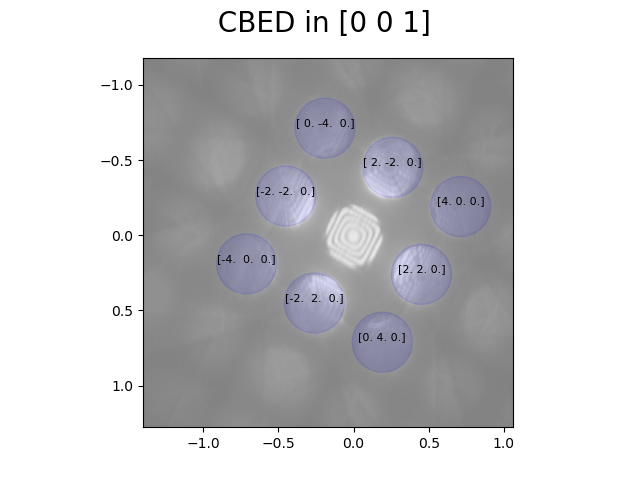

In [22]:
# ----- Input ---------
rotation_angle = 15 # in degrees
convergence_angle = .20  # in 1/nm
pixel_size = 10*1e-4 *1.2
# -------------------
tags_simulation = atoms.info['diffraction']

#scale_300mm
#g = gx = gy = ft.get_slope(sidpy_dataset.x.values) # does not work here

g = gx = gy = pixel_size

print(f'Scale is {g:.4f} 1/nm per pixel')
extent= np.array([-center[0]*gx, (diff_pattern.shape[0]-center[0])*gx,(diff_pattern.shape[1]-center[1])*gy, -center[1]*gy])

# rotation matrix  around z axis to coincide with spots
angle = np.radians(rotation_angle)
c = np.cos(angle)
s = np.sin(angle)
r_mat = np.array([[c,-s,0],[s,c,0],[0,0,1]])
rotation_matrix = r_mat


spots_simulation =  np.dot(tags_simulation['allowed']['g'], rotation_matrix)
spots_ZOLZ = spots_simulation[tags_simulation['allowed']['ZOLZ']]
fig = plt.figure()
fig.suptitle(' CBED in ' + str(tags_experiment['zone_hkl']), fontsize=20) 
# plt.scatter(spots_ZOLZ[:,0], spots_ZOLZ[:,1], c='red',  alpha = 0.2,   label='spots')
plt.imshow(np.log2(1+diff_pattern).T,cmap="gray", extent=(extent), vmin=np.max(np.log2(1+diff_pattern))*0.5);

for i in range(len(tags_simulation['allowed']['g'])):
    if tags_simulation['allowed']['ZOLZ'][i]:
        if np.linalg.norm(tags_simulation['allowed']['g'][i]) <1:
            disk = plt.Circle((spots_simulation[i,0], spots_simulation[i,1] ), convergence_angle, alpha=0.1, color='blue')
            plt.gca().add_artist(disk) 
            plt.text(spots_simulation[i,0], spots_simulation[i,1],str(tags_simulation['allowed']['hkl'][i]),
                    fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')
    

### What does the above figure convey?




In [33]:
from skimage.feature import blob_dog, blob_log, blob_doh


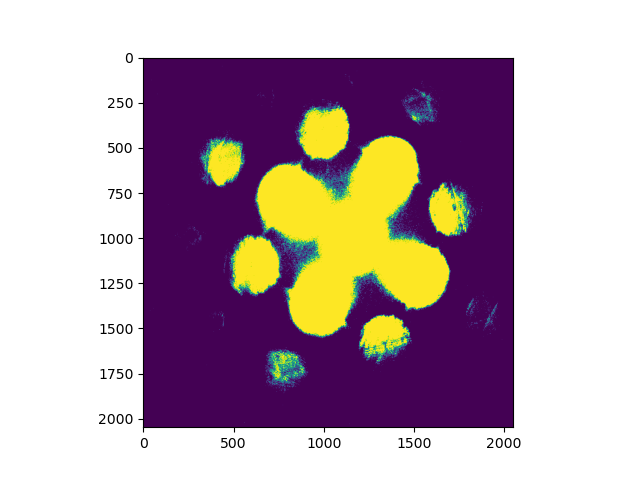

In [52]:
dif  = np.log2(1+diff_pattern).T
dif[dif < dif.max()*.8] = 0.
dif[dif > 0] = 1.

fig = plt.figure()

plt.imshow(dif)

In [62]:

blobs_log = blob_log(dif.T, max_sigma=300, num_sigma=100, threshold=.5)
print(blobs_log.shape)

KeyboardInterrupt: 

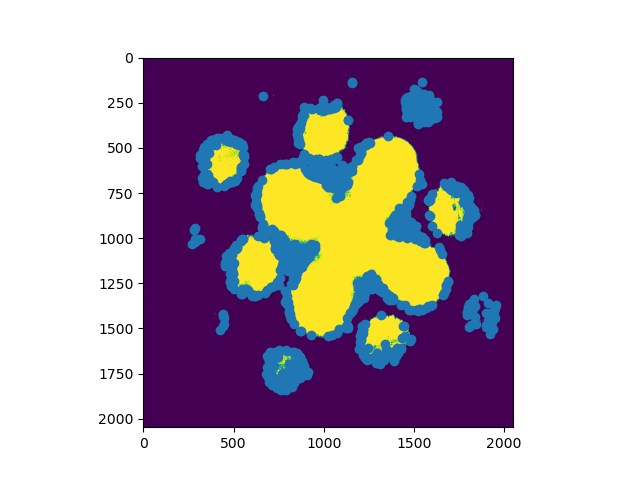

In [61]:
plt.figure()
plt.imshow(dif)
plt.scatter(blobs_log[:, 0], blobs_log[:, 1])

In [ ]:
fig = plt.figure()
fig.suptitle(' CBED in ' + str(tags_experiment['zone_hkl']), fontsize=20) 
# plt.scatter(spots_ZOLZ[:,0], spots_ZOLZ[:,1], c='red',  alpha = 0.2,   label='spots')
plt.imshow(np.log2(1+diff_pattern).T,cmap="gray", extent=(extent), vmin=np.max(np.log2(1+diff_pattern))*0.5);

### What is the accuracy?




## Conclusion

We need more information for the spot pattern than for the ring pattern.

The convergent beam pattern has the same kinematic diffraciton information but provides additional dynamical diffraction information.

A comparison between simulation and experiment can be very precise.

In principle, if you have the spots and the approximate center you can let an optimization routine do all the scaling for you (which we will do in the high resultion imaging section).

